### Lighting Science Final Project  <br>
Takehiro Izumi, Amrit Shaw, Takuma Tsuruta <br>


Import necesarry librarieas and try to connect the DMX controller and JETI spectroradiometers.

In [1]:
from DMXEnttecPro import Controller
from DMXEnttecPro.utils import get_port_by_serial_number, get_port_by_product_id
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime
import os
import luxpy as lx  # package for color science calculations
from luxpy.toolboxes import spectro as sp
import glob
from luxpy.toolboxes import spdbuild as spb

cieobs = '1964_10'


class DMXHandler():
    def __init__(self, product_id) -> None:
        self.product_id = product_id
        self.dmx = None
        self.is_connected = False
        self.all_channels = [0, 1, 2, 3, 4]

    def open(self):
        try:
            port = get_port_by_product_id(self.product_id)
            self.dmx = Controller(port)
            print('DMX connected')
            self.is_connected = True
        except:
            self.dmx = None
            print('no DMX connection')
            self.is_connected = False

    def control_channels(self, dr_value_in, channels_idx=[0, 1, 2, 3, 4]):
        # example:  turn on R 100, B 10
        #   dmx.control_channels(dr_value_in=[100, 10], channels_idx=[0, 1])
        
        if len(channels_idx) != len(dr_value_in):
            print('Both input variables should have same length.')
        for c in self.all_channels:
            self.dmx.set_channel(c, 0)

        for (c, v) in zip(channels_idx, dr_value_in):
            self.dmx.set_channel(c+1, int(v))
        self.dmx.submit()

    def close(self):
        if self.is_connected:
            dmx.set_channel(1, 0)
            dmx.submit()
            self.dmx.close()


dmx = DMXHandler(24577)

dmx.open()
sp.init('jeti')

no DMX connection


<module 'luxpy.toolboxes.spectro.jeti.jeti' from 'c:\\Users\\robgy\\anaconda3\\lib\\site-packages\\luxpy\\toolboxes\\spectro\\jeti\\jeti.py'>

Turn on the laser pointer in JETI and check the measurement point.

In [90]:
if dmx.is_connected:
    sp.jeti.set_laser(laser_on=True)
    dmx.control_channels(dr_value_in=[0, 0, 0, 0, 0])
    time.sleep(2)
    sp.jeti.set_laser(laser_on=False)


In [2]:

def measureSPD(channels_idx, dr_value_in):
    if not dmx.is_connected:
        return None
    # Avoid to measure with 0 output value because JETI can't be used in a dark room.
    if np.sum(dr_value_in) == 0:
        return None
    dmx.control_channels(dr_value_in=dr_value_in, channels_idx=channels_idx)
    time.sleep(0.2)
    spd = sp.jeti.get_spd()
    return spd


def measureSPDforCalibration(channels_idx, dr_value_in):
    measured_spd_all = []
    for channel in channels_idx:
        measured_spd = []
        for v in dr_value_in:
            print(channel, v)
            spd = measureSPD(dr_value_in=[v], channels_idx=[channel])
            measured_spd.append(spd)

        #  fill None data as zero spectrum
        if measured_spd[0] is None:
            measured_spd[0] = measured_spd[1].copy()
            measured_spd[0][-1] = measured_spd[0][-1]*0

        measured_spd = np.asarray(measured_spd)
        first_spd = measured_spd[0].copy()
        after_first_spd_intensity = measured_spd[1:, 1, :].copy()
        spd_channel = np.concatenate(
            [first_spd, after_first_spd_intensity], axis=0)
        measured_spd_all.append(spd_channel)
    return measured_spd_all


def calibrate(filename=None):
    # try to load existing calibration data when filename is specified.
    if filename is not None:
        return np.load(filename)

    if not dmx.is_connected:
        print('Connect DMX controller to run calibration.')
        return False

    now = datetime.datetime.now()
    filename = './output/data_' + now.strftime('%Y%m%d_%H%M%S')
    if not os.path.exists(os.path.dirname(filename)):
        os.mkdir(os.path.dirname(filename))

    channels = [0, 1, 2, 3, 4]
    dr_value_in = np.concatenate([np.arange(0, 50, 5), np.arange(50, 255, 10)])
    # dr_value_in = np.arange(0, 255, 120)
    if dr_value_in[-1] < 255:  # make sure that the last value is max.
        dr_value_in = np.append(dr_value_in, 255)

    measured_spd_all = measureSPDforCalibration(channels, dr_value_in)
    np.savez(filename, spd=measured_spd_all,
             dr_value_in=dr_value_in, channels=channels)
    return np.load(filename+'.npz')


Calibrate the light source (or load existing calibrate data). <br>
Calculate output-value v.s. output-luminance characteristic using poly fit function. <br>
Show the graphs if specified (is_plot = True).

In [3]:
# f = None
# f = 'output/_data_20230424_180235.npz'
f = 'output/data_20230428_123213.npz'
f = 'data_20230502_162201_groupM.npz'
# is_plot = False
is_plot = False
data = calibrate(f)

In [9]:

dr_value = data['dr_value_in']
channels = data['channels']
measured_spd_all = data['spd']
print('dr_value_in shape', dr_value.shape)
print('spd shape', measured_spd_all.shape)

print(dr_value.shape, measured_spd_all.shape)
print(dr_value)

labels = ['R', 'G', 'B', 'WH', 'A', 'UV']
print(channels)

normL2drv = []
for i, channel in enumerate(channels):
    luminance = lx.spd_to_power(
        measured_spd_all[i], ptype='pu', cieobs=cieobs)[:, 0]
    normalized_luminance = luminance / max(luminance)
    # normalized_luminance = (luminance-min(luminance)) / (max(luminance)-min(luminance))

    z = np.polyfit(luminance, dr_value, 6)
    z_norm = np.polyfit(normalized_luminance, dr_value, 6)

    func = np.poly1d(z)
    func_norm = np.poly1d(z_norm)

    normL2drv.append(func_norm)    

    if is_plot:
        plt.figure()
        plt.plot(dr_value, luminance, '.')
        plt.plot(func(luminance), luminance, '-')
        plt.xlabel('driver value indices')
        plt.ylabel('Luminance [cd/m^2]')
        plt.title(labels[i])
        plt.savefig('output/luminance_output_{}.png'.format(labels[i]))

        plt.figure()
        plt.plot(dr_value, normalized_luminance, '.')
        plt.plot(func_norm(normalized_luminance), normalized_luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Normalized Luminance')
        plt.title(labels[i])
        plt.savefig('output/normL_output_{}.png'.format(labels[i]))

        lx.SPD(np.vstack([measured_spd_all[i][0, :].copy(), measured_spd_all[i][-1, :].copy()])).plot()
        plt.title(labels[i])
        plt.savefig('output/spd_255_{}.png'.format(labels[i]))


dr_value_in shape [  0   5   7  10  15  23  35  52  77 115 171 240 255]
spd shape (6, 19, 471)
(13,) (6, 19, 471)
[  0   5   7  10  15  23  35  52  77 115 171 240 255]
[0 1 2 3 4 5]


TypeError: expected x and y to have same length

In [29]:
def getPrimarySPD(channels_idx):
    spd_p = []
    for c in channels_idx:
        spd = np.vstack((measured_spd_all[c, 0, :].copy(), measured_spd_all[c, -1, :].copy()))
        # spd[-1] = spd[-1] - measured_spd_all[c][0][-1]
        spd_p.append(spd)
    return np.vstack([spd_p[0][0]] +
                         [s[-1] for s in spd_p])

def getDriverValues(channels_idx, weights):
    driver_values = []
    for i, w in zip(channels_idx, weights[0]):
        if w <= 0:
            driver_values.append(0)
            print("The weight was negative, so may not achieve accurate result.")
        elif w >= 1:
            driver_values.append(255)
        else:
            v = normL2drv[i](w)
            if v < 0:
                v = 0
            elif v > 255:
                v = 255
            driver_values.append(v)
    driver_values = np.around(driver_values)
    return np.asarray(driver_values, dtype = np.uint8)

def calculateOptimizedSPD(spd_p, weights):
    weighted_p = spd_p[0:2].copy()
    weighted_p[-1] *= 0
    for i, (p, w) in enumerate(zip(spd_p[1:], weights[0])):
        weighted_p[-1] += p*w
    return weighted_p

def showMixedSPD(spd_p, spd_optimized): #weighted_p is the optimized spd and spd_p is the primary stacked spd
    fig,ax = plt.subplots(1,2, figsize=(18,6))
    plt.sca(ax[0]); 
    plt.title('Primaries')
    lx.SPD(spd_p).plot()
    plt.sca(ax[1]); 
    plt.title('Mixed SPD for the target')
    lx.SPD(spd_optimized).plot()

def evaluate(spd, xyz_t):
    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
        
    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    print("Luminance [cd/m2] : {:1.1f}".format(l[0][0]))
    
    print("xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_obtained[0]))
    print("Target xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_t[0]))
    
    # print((lx.xyz_to_cct(xyz_obtained, cieobs=cieobs, out='cct'))[0])

    cct, duv = lx.xyz_to_cct(xyz_obtained, cieobs=cieobs, out='cct,duv')
    Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')

    print("CCT: {:1.1f}".format(cct[0][0]))
    print("Duv: {:1.5f}".format(duv[0][0]))
    
    print("Rf: {:1.1f}".format(Rf[0][0]))
    print("Rg: {:1.1f}".format(Rg[0][0]))
    print("LER: {:1.1f}".format((lx.spd_to_ler(spd))[0,0]))

    get_color_difference(spd,xyz_t)


    Yuv_obtained = lx.xyz_to_Yuv(xyz_obtained)
    Yuv_target = lx.xyz_to_Yuv(xyz_t)


    
    Y_t, u_t, v_t = lx.utils.asplit(Yuv_target)
    Y, u, v = lx.utils.asplit(Yuv_obtained)
    
    fig, ax = plt.subplots(1,2,figsize=(18,6))


    ax[0].plot(u, v,
            color ='r', marker = 'o', linestyle = 'none', label='obtained')
    ax[0].plot(u_t, v_t,
            color ='b', marker ='d', linestyle = 'none', label='target')
    ax[0].set_xlabel("u'")  # set x-axis label
    ax[0].legend()
    ax[0].set_ylabel("v'")  # set y-axis label
    
    lx.cri.plot_tm30_cvg(spd, axh=ax[1]) # maybe this is not using cieobs=1964_10, so the cct value could be different.

    lx.plotSL(cieobs=cieobs, cspace='Yuv', DL=False,
        BBL=True, diagram_colors=True, axh=ax[0])

def get_color_difference(spd, xyz_t):

    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    
    luv_obt = lx.xyz_to_luv(xyz_obtained)
    luv_tar = lx.xyz_to_luv(xyz_t)

    lab_obt = lx.xyz_to_lab(xyz_obtained)
    lab_tar = lx.xyz_to_lab(xyz_t)

    Yuv_obt = lx.xyz_to_Yuv(xyz_obtained, cieobs=cieobs)
    Yuv_tar = lx.xyz_to_Yuv(xyz_t, cieobs=cieobs)

    # Calculate L*u*v* and L*a*b* color difference manually:

    DEuv_luv = np.sqrt((luv_tar[0,0] - luv_obt[0,0])**2 + (luv_tar[0,1] - luv_obt[0,1])**2 + (luv_tar[0,2] - luv_obt[0,2])**2 )

    DEab_lab = np.sqrt((lab_tar[0,0] - lab_obt[0,0])**2 + (lab_tar[0,1] - lab_obt[0,1])**2 + (lab_tar[0,2] - lab_obt[0,2])**2)

    DEuv_uv = np.sqrt((Yuv_tar[0,1] - Yuv_obt[0,1])**2 + (Yuv_tar[0,2] - Yuv_obt[0,2])**2 )

    
    
    print('Obtained Lu*v*: {0[0]:1.4f}, {0[1]:1.4f}, {0[2]:1.4f}'.format(luv_obt[0]))
    print('Target Lu*v*: {0[0]:1.4f}, {0[1]:1.4f}, {0[2]:1.4f}'.format(luv_tar[0]))

    print('Obtained u\': {:1.4f}'.format(Yuv_obt[0,1]))
    print('Target u\': {:1.4f}'.format(Yuv_tar[0, 1]))
    print('Obtained v\': {:1.4f}'.format(Yuv_obt[0, 2]))
    print('Target v\': {:1.4f}'.format(Yuv_tar[0,2]))

    print("color difference in LUV space: {:1.3f}".format(DEuv_luv))
    print("color difference in Lab space: {:1.3f}".format(DEab_lab))

    # print("color difference in UV space: {:1.3f}".format(DEuv_uv))
    if DEuv_uv < 0.001:
        print("JND in u\'v\' chromaticity:",0)
    else:
        jnd = int(np.ceil(DEuv_uv/0.006))
        print("JNDs in u\'v\' chromaticity:", jnd)

    # print("color difference in UV space: {:1.3f}".format(DEuv_uv))
    print("JNDs in u\'v\' chromaticity based on CIELAB:{0:1.4f}".format(DEab_lab))
  

def color_mixing(xyz_t, channels_idx):
    Yxy_t = lx.xyz_to_Yxy(xyz_t)
    spd_p = getPrimarySPD(channels_idx=channels_idx)
    xyz_p = lx.spd_to_xyz(spd_p, relative=False, cieobs=cieobs) # always mention CIE when convert spd to colorimetric value
    Yxy_p = lx.xyz_to_Yxy(xyz_p)

    M_xyz = spb.colormixer_pinv(xyz_t, xyz_p, input_fmt='xyz') 
    # M_Yxy = spb.colormixer_pinv(Yxy_t, Yxy_p, input_fmt='Yxy') 
    M = M_xyz
    driver_values = getDriverValues(channels_idx, M)

    print('Selected channels:', [labels[c] for c in channels_idx])
    print('Optimized primary contributions:', M[0])
    print('driver values of the light source:', driver_values)
    

    print('\n-----------Optimized------------')
    spd_optimized = calculateOptimizedSPD(spd_p, M)
    showMixedSPD(spd_p, spd_optimized)
    evaluate(spd_optimized, xyz_t)
    
    if dmx.is_connected:
        print('\n------------Measured------------')
        spd_measured = measureSPD(channels_idx, driver_values)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)

    return spd_optimized


Selected channels: ['R', 'G', 'B']
Optimized primary contributions: [6.8414e-02 5.8637e-02 2.7699e-02]
driver values of the light source: [45 35 14]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 60.7
Rg: 122.5
LER: 269.3
Obtained Lu*v*: 100.0000, 16.4922, 6.9522
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2105
Target u': 0.2105
Obtained v': 0.4737
Target v': 0.4737
color difference in LUV space: 0.000
color difference in Lab space: 0.000
JND in u'v' chromaticity: 0
JNDs in u'v' chromaticity based on CIELAB:0.0000


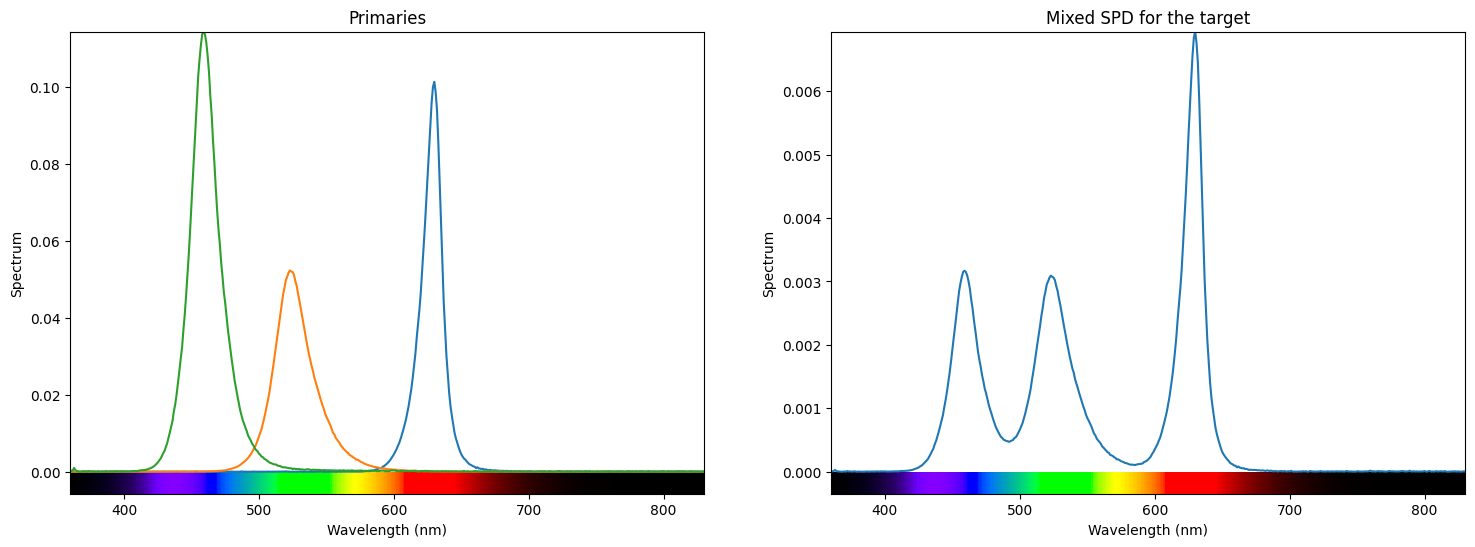

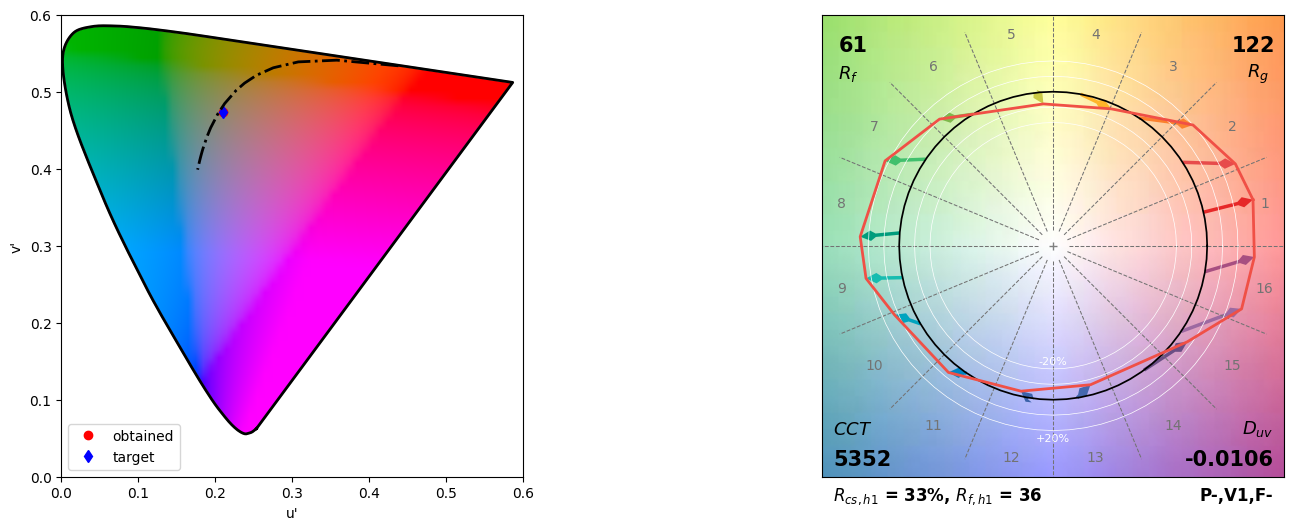

In [30]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2]
spd3 = color_mixing(xyz_t, channels_idx)

In [20]:


xyz_obtained = [[101,100,102]]


luv_obt = lx.xyz_to_luv(xyz_obtained)
luv_tar = lx.xyz_to_luv(xyz_t)

Yuv_obt = lx.xyz_to_Yuv(xyz_obtained, cieobs=cieobs)
Yuv_tar = lx.xyz_to_Yuv(xyz_t, cieobs=cieobs)

# Calculate L*u*v* color difference manually:
DEuv_luv = np.sqrt((luv_tar[0,0] - luv_obt[0,0])**2 + (luv_tar[0,1] - luv_obt[0,1])**2 + (luv_tar[0,2] - luv_obt[0,2])**2 )
DEuv_uv = np.sqrt((Yuv_tar[0,1] - Yuv_obt[0,1])**2 + (Yuv_tar[0,2] - Yuv_obt[0,2])**2 )



DE = lx.deltaE.DE_cspace(xyz_obtained,xyz_t)

DE_c=lx.deltaE.DE2000(xyz_obtained,xyz_t)
DE_c,DEuv_luv




(array([[2.0485e+00]]), 2.8416900202319324)

## 4-channels colormixing

Selected channels: ['R', 'G', 'B', 'A']
Optimized primary contributions: [4.7630e-02 5.3404e-02 2.7823e-02 3.5581e-02]
driver values of the light source: [30 32 15 20]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 74.7
Rg: 114.3
LER: 289.1
Obtained Lu*v*: 100.0000, 16.4922, 6.9522
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2105
Target u': 0.2105
Obtained v': 0.4737
Target v': 0.4737
color difference in LUV space: 0.000
JND in u'v' chromaticity: 0


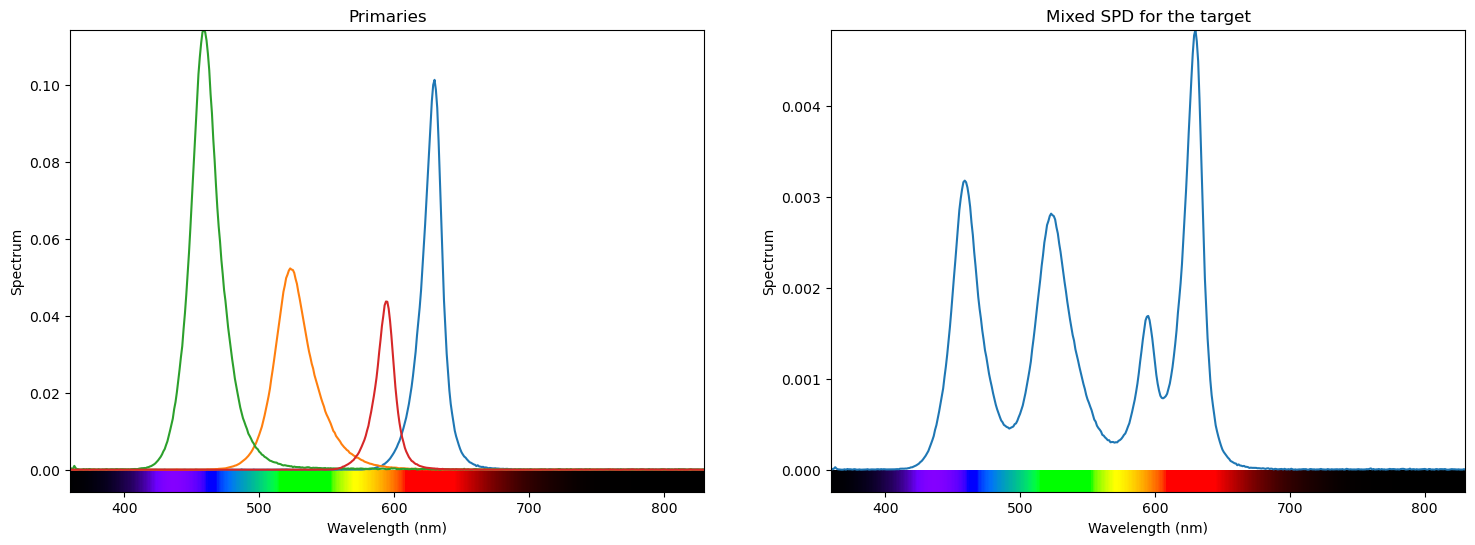

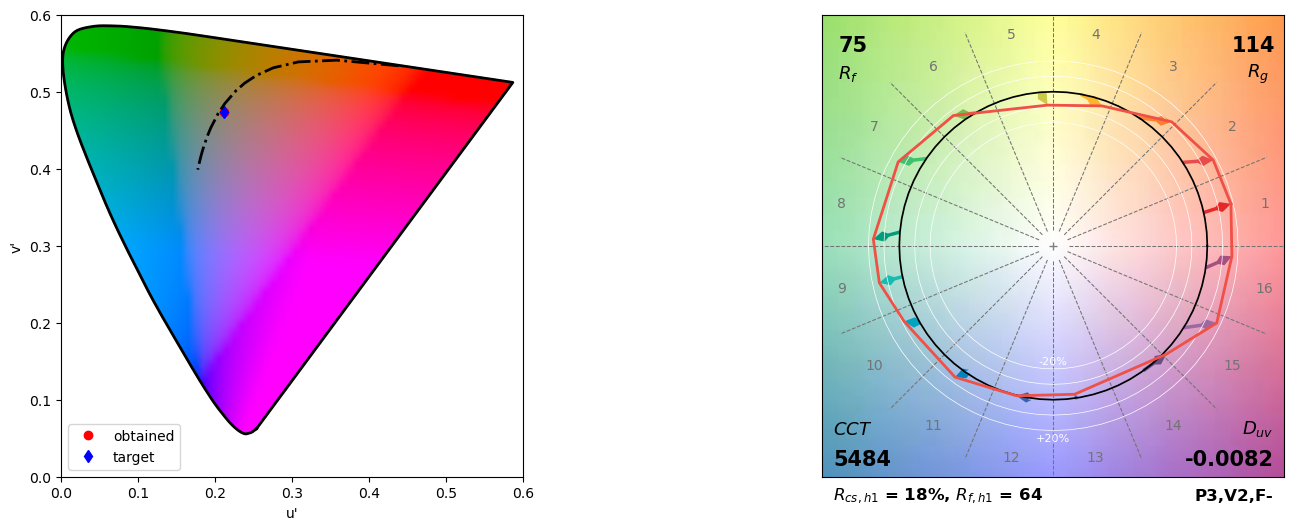


------------Measured------------
Luminance [cd/m2] : 107.5
xyz : [ 107.1, 107.5, 117.3 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 6008.5
Duv: -0.00452
Rf: 75.5
Rg: 112.1
LER: 286.0
Obtained Lu*v*: 102.8178, 12.0506, -1.7965
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2069
Target u': 0.2105
Obtained v': 0.4670
Target v': 0.4737
color difference in LUV space: 10.208
JNDs in u'v' chromaticity: 2


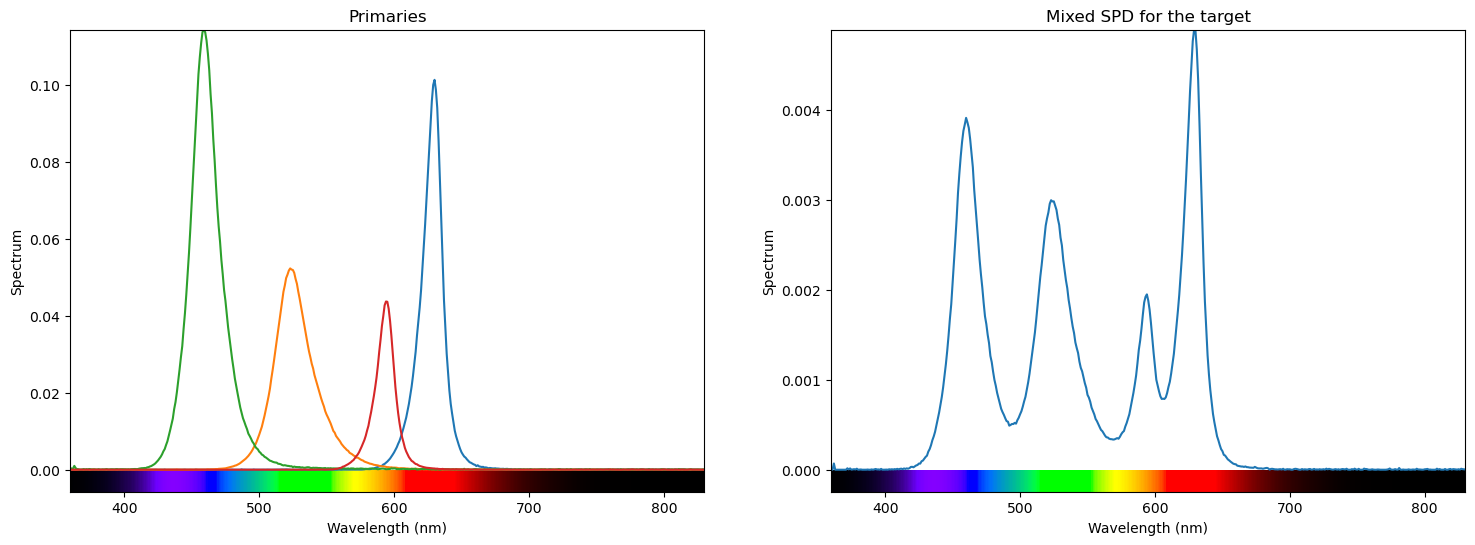

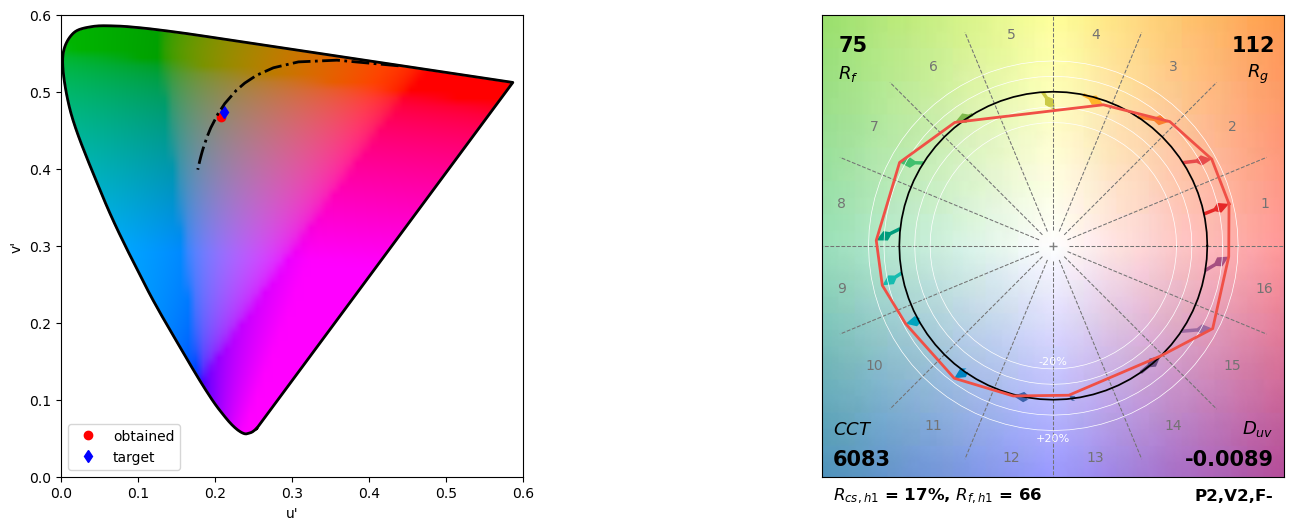

In [108]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2, 4]
spd4 = color_mixing(xyz_t,  channels_idx)

### 5 channels mixing

Selected channels: ['R', 'G', 'B', 'WH', 'A']
Optimized primary contributions: [2.8571e-02 3.1570e-02 1.4967e-02 4.1600e-02 2.1281e-02]
driver values of the light source: [16 16  5 25  9]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 88.0
Rg: 110.7
LER: 305.3
Obtained Lu*v*: 100.0000, 16.4922, 6.9522
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2105
Target u': 0.2105
Obtained v': 0.4737
Target v': 0.4737
color difference in LUV space: 0.000
JND in u'v' chromaticity: 0


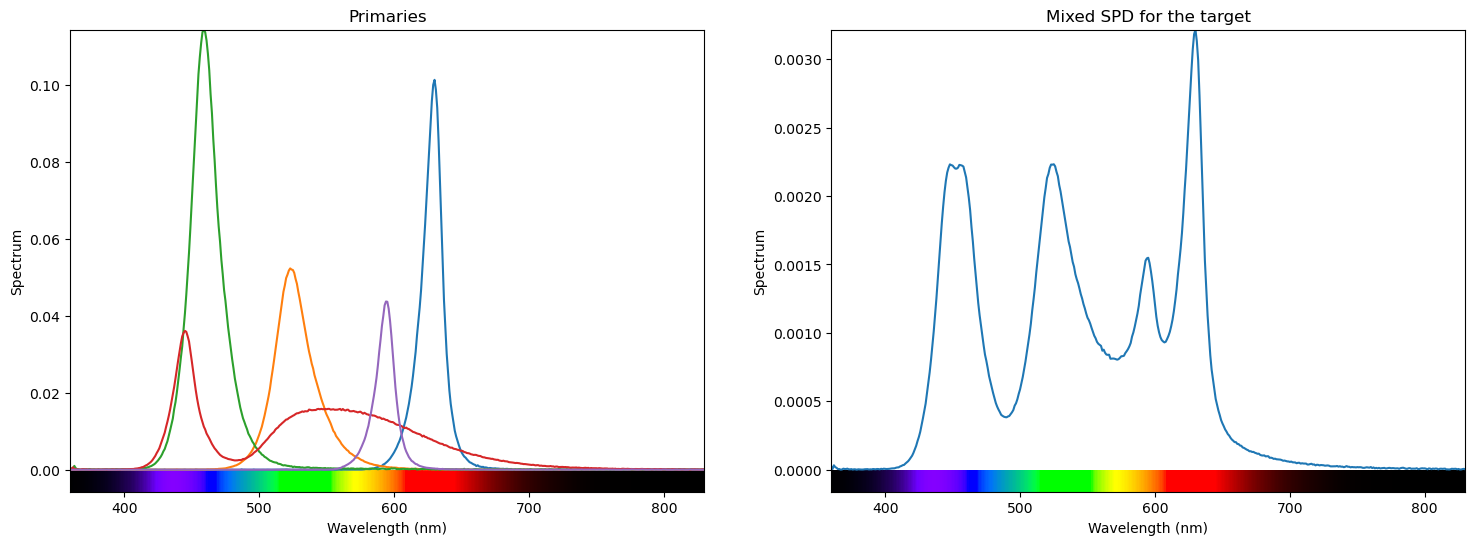

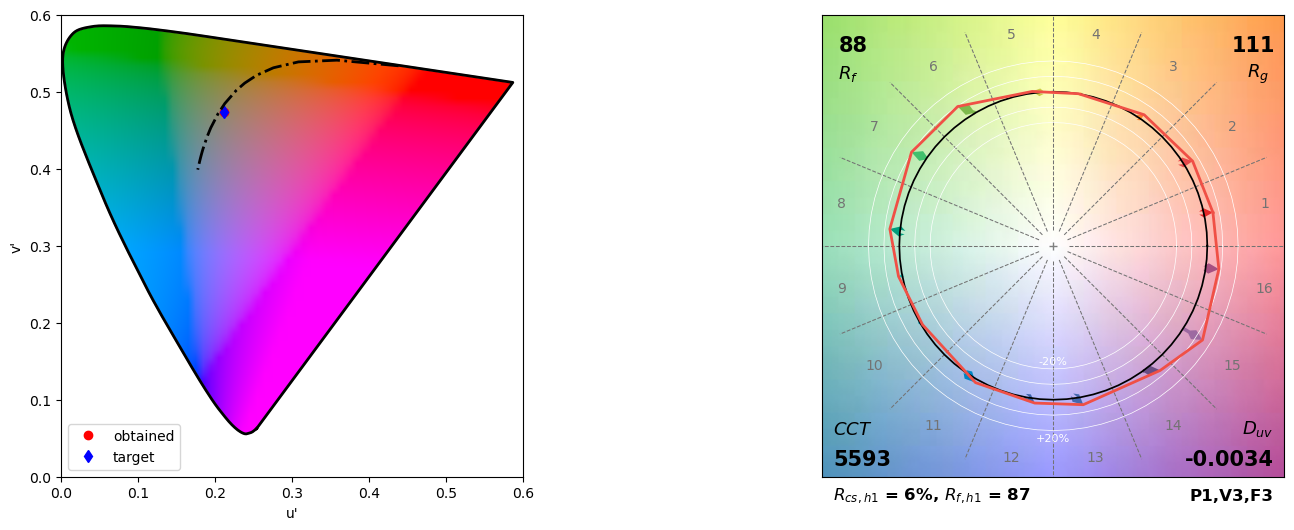


------------Measured------------
Luminance [cd/m2] : 112.2
xyz : [ 108.7, 112.2, 94.1 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5077.4
Duv: 0.00290
Rf: 89.9
Rg: 107.2
LER: 323.6
Obtained Lu*v*: 104.5453, 15.8971, 25.2350
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2095
Target u': 0.2105
Obtained v': 0.4869
Target v': 0.4737
color difference in LUV space: 18.849
JNDs in u'v' chromaticity: 3


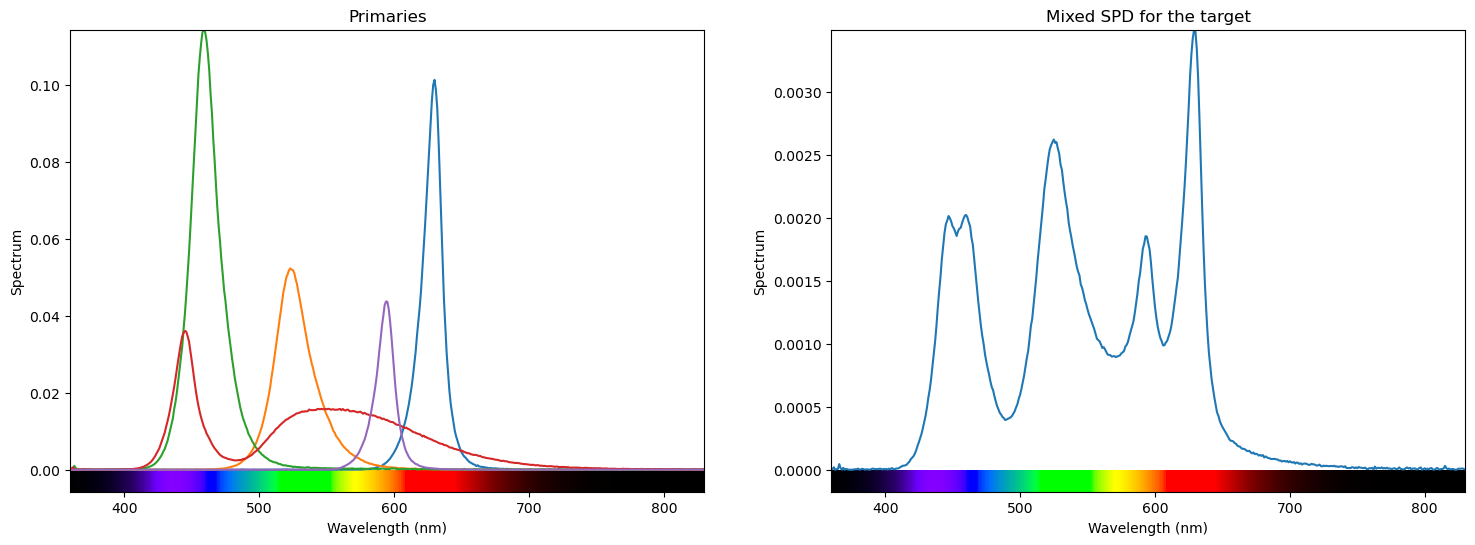

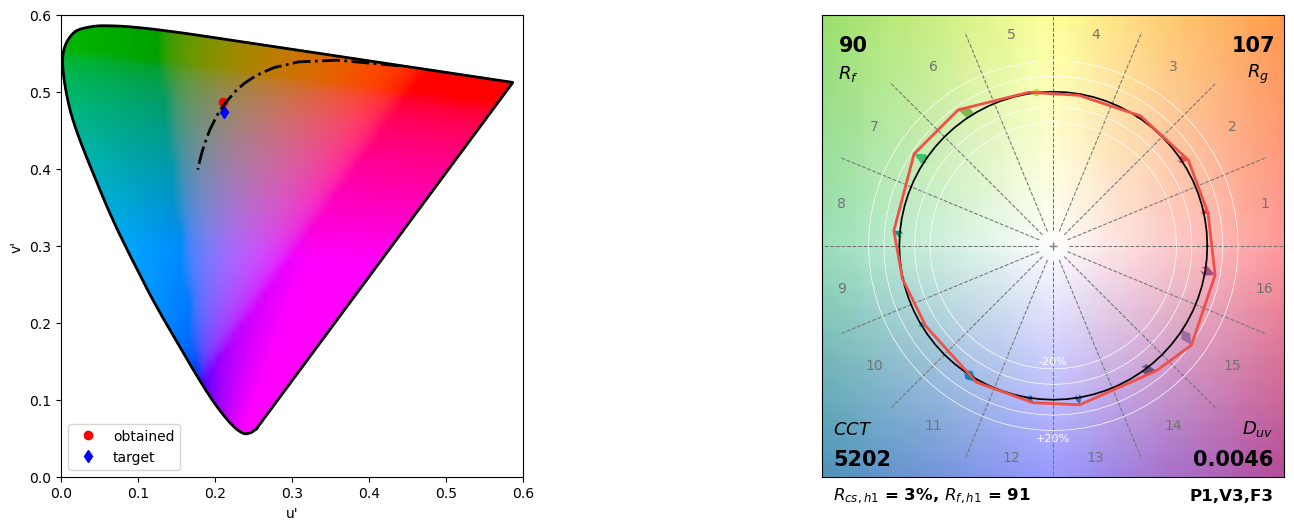

In [109]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2, 3, 4]
spd5 = color_mixing(xyz_t,  channels_idx)

### Multi-objective optimizer

In [110]:
def spectralOptimization(channels_idx, target=None, tar_type='xyz', Rf_Rg=None, LER=None, method='Nelder-Mead'):
        
    methods = ['Nelder-Mead', 'particleswarm', 'demo']
    if method not in methods:
        print('Specify correct method.', methods)
        return 


    tar_types = ["xyz_t, Yxy_t, cct_t"]    
    if tar_type == 'xyz':
        xyz_t = target # for the evaluation process
    elif tar_type =='Yxy':
        
        xyz_t = lx.Yxy_to_xyz(target) # for the evaluation process
    elif tar_type == 'cct':
        
        xyz_t = lx.cct_to_xyz(target) # for the evaluation process
    else:
        print('Specify correct target type.', tar_types)
        return 

    # define function that calculates several objectives at the same time (for speed):
    def spd_to_cris(spd):
        Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')
        return np.vstack((Rf, Rg))

    def spd_to_LER(spd):
        LER = lx.spd_to_ler(spd, cieobs=cieobs)
        return LER.T
    
    obj_fcn = []
    obj_tar_vals = []
    if Rf_Rg is not None:
        obj_fcn.append((spd_to_cris, 'Rf', 'Rg'))
        obj_tar_vals.append(Rf_Rg) 
    if LER is not None:
        obj_fcn.append((spd_to_LER, 'LER'))
        obj_tar_vals.append(LER) 
       

    spd_p = getPrimarySPD(channels_idx=channels_idx)
    so = spb.SpectralOptimizer(target = target,
                                tar_type = tar_type,
                                wlr = [360,830,1], 
                                cieobs = cieobs, 
                                out = 'spds,primss,Ms,results',
                                optimizer_type = '3mixer',
                                prim_constructor = None, 
                                prims = spd_p,
                                obj_fcn = spb.ObjFcns(f = obj_fcn,
                                                    ft = obj_tar_vals),
                                                    # fw = obj_fcn_weights),
                                minimizer = spb.Minimizer(method=method),
                                verbosity = 0)

    # start optimization:
    start_time = time.time()
    S, M = so.start(out='spds,Ms')
    print('Running time for the optimization: {:.2f} sec'.format(time.time()-start_time))

    driver_values = getDriverValues(channels_idx, M)
    print('Optimized primary contributions:', M[0])
    print('driver values values of the light source:', driver_values)

    def _result(spd):
        xyz = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
        Yxy = lx.xyz_to_Yxy(xyz)
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        Rf, Rg = spd_to_cris(spd)
        res_LER = spd_to_LER(spd)

        # _cct, _duv = lx.colortf(spd, tf = 'spd>cct', 
        #                  bwtf = {'cieobs':cieobs}, 
        #                  fwtf = {'cieobs':cieobs, 'out':'cct,duv'}) # note that this is the same as a call to spd_to_xyz followed by a coll to xyz_to_cct

        print('Results (optim,target):')
        print("Rf: ({:1.2f}, {:1.2f})".format(Rf[0], np.nan if Rf_Rg is None else Rf_Rg[0]))
        print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], np.nan if Rf_Rg is None else Rf_Rg[1]))
        print("CCT [K]: ({:1.1f}, {:1.1f})".format(cct[0][0], np.nan if tar_type != 'cct' else target[0][0]))
        print("Duv: ({:1.4f}, {:1.4f})".format(duv[0][0], np.nan if tar_type != 'cct' else target[0][-1]))

        print("LER [lm/W]: ({:1.1f}, {:1.1f})".format(res_LER[0][0], np.nan if LER is None else LER))
    
    print('\n------Optimized Result-------')
    _result(S)
    showMixedSPD(spd_p, S)
    evaluate(S, xyz_t)
    
    if dmx.is_connected:
        print('\n------Measured Result-------')
        spd_measured = measureSPD(channels_idx, driver_values)
        _result(spd_measured)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)





Running time for the optimization: 5.69 sec
Optimized primary contributions: [6.5257e-03 3.7837e-02 5.1765e-02 1.7212e-02 5.6085e-02]
driver values values of the light source: [ 0 21 32  7 33]

------Optimized Result-------
Results (optim,target):
Rf: (78.90, 80.00)
Rg: (91.60, 95.00)
CCT [K]: (31724.0, nan)
Duv: (-0.0023, nan)
LER [lm/W]: (286.3, 350.0)
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 200.0 ]
Target xyz : [ 100.0, 100.0, 200.0 ]
CCT: 31724.0
Duv: -0.00225
Rf: 78.9
Rg: 91.6
LER: 250.9
Obtained Lu*v*: 100.0000, -20.8283, -77.0191
Target Lu*v*: 100.0000, -20.8283, -77.0191
Obtained u': 0.1818
Target u': 0.1818
Obtained v': 0.4091
Target v': 0.4091
color difference in LUV space: 0.000
JND in u'v' chromaticity: 0


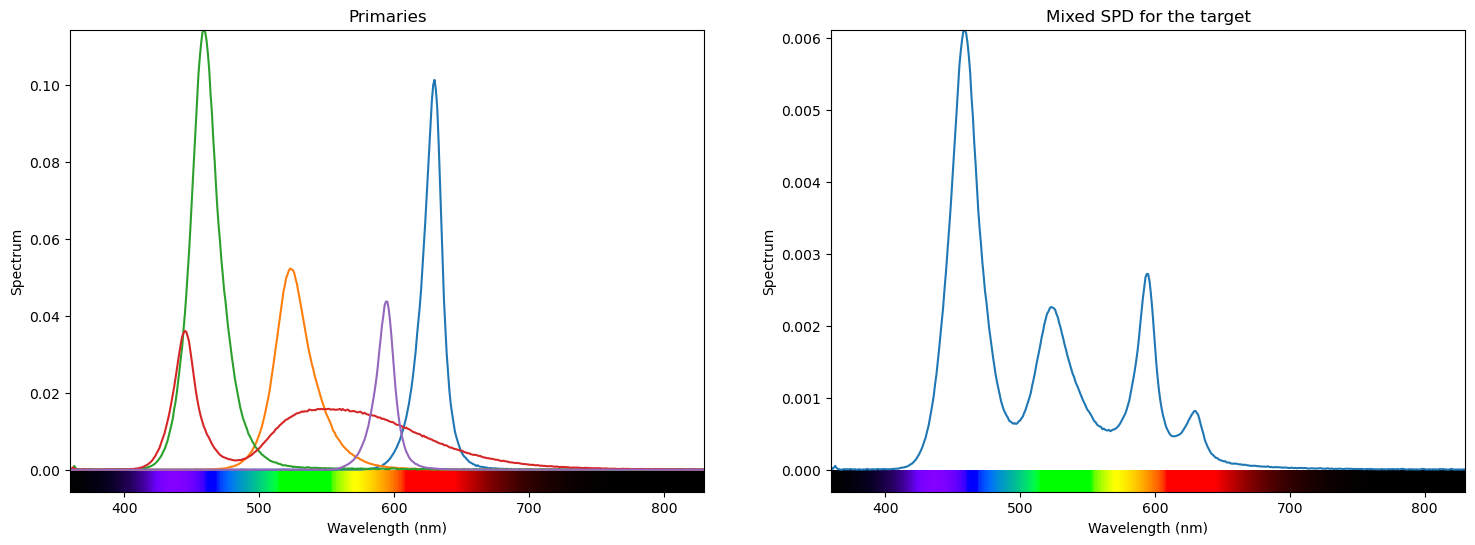

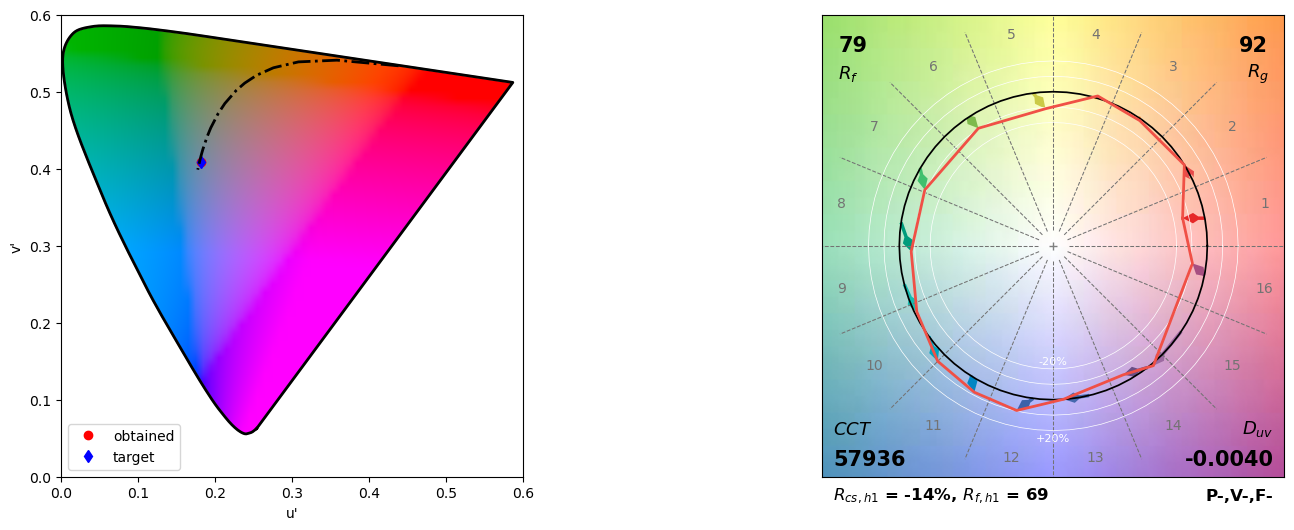


------Measured Result-------
Results (optim,target):
Rf: (73.58, 80.00)
Rg: (82.64, 95.00)
CCT [K]: (26913.1, nan)
Duv: (0.0091, nan)
LER [lm/W]: (301.3, 350.0)
Luminance [cd/m2] : 109.5
xyz : [ 101.4, 109.5, 205.8 ]
Target xyz : [ 100.0, 100.0, 200.0 ]
CCT: 26913.1
Duv: 0.00913
Rf: 73.6
Rg: 82.6
LER: 265.8
Obtained Lu*v*: 103.5645, -35.1658, -68.6228
Target Lu*v*: 100.0000, -20.8283, -77.0191
Obtained u': 0.1717
Target u': 0.1818
Obtained v': 0.4174
Target v': 0.4091
color difference in LUV space: 16.993
JNDs in u'v' chromaticity: 3


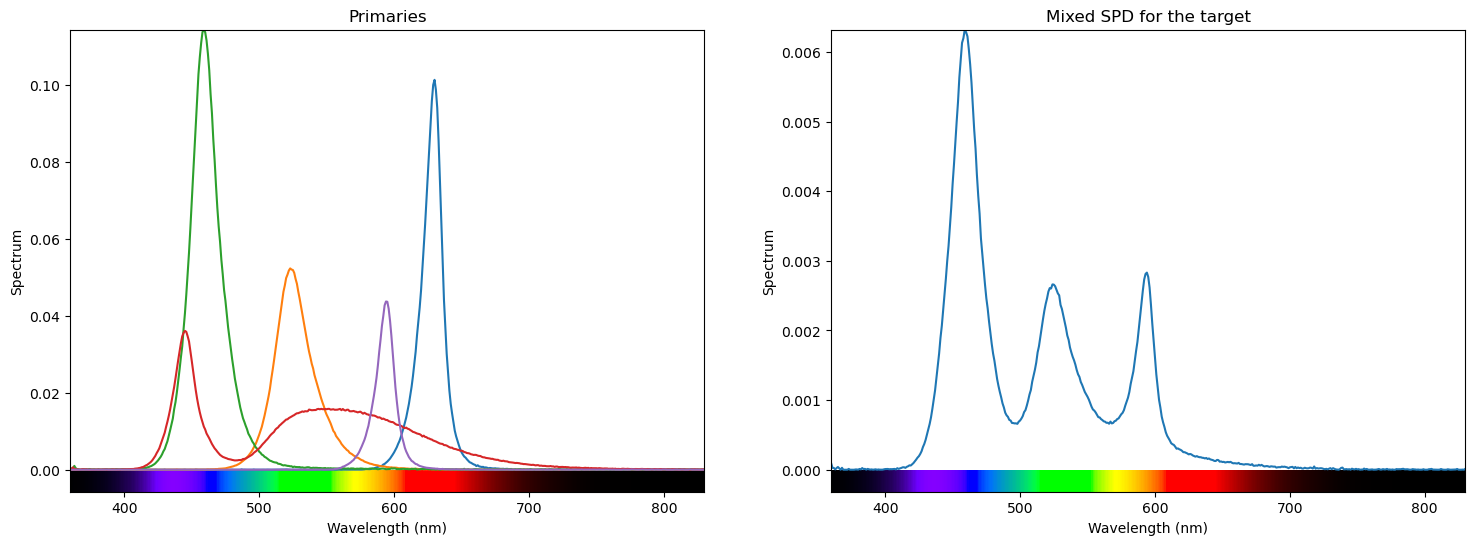

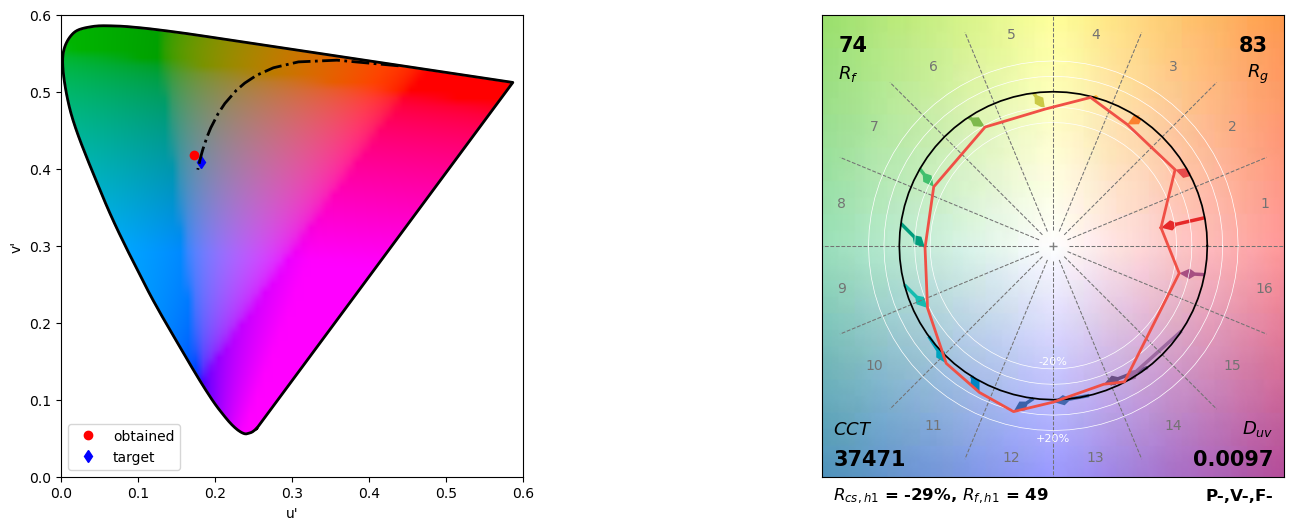

Running time for the optimization: 6.16 sec
Optimized primary contributions: [1.3065e-02 2.1527e-02 3.2801e-03 5.0078e-02 5.3183e-02]
driver values values of the light source: [ 4  9  0 31 31]

------Optimized Result-------
Results (optim,target):
Rf: (80.88, 80.00)
Rg: (98.48, 95.00)
CCT [K]: (4065.1, 4000.0)
Duv: (-0.0020, -0.0030)
LER [lm/W]: (377.3, 350.0)
Luminance [cd/m2] : 100.0
xyz : [ 102.5, 100.0, 68.4 ]
Target xyz : [ 102.5, 100.0, 68.4 ]
CCT: 4065.1
Duv: -0.00199
Rf: 80.9
Rg: 98.5
LER: 356.2
Obtained Lu*v*: 100.0000, 37.6646, 38.4010
Target Lu*v*: 100.0000, 37.6646, 38.4010
Obtained u': 0.2268
Target u': 0.2268
Obtained v': 0.4979
Target v': 0.4979
color difference in LUV space: 0.000
JND in u'v' chromaticity: 0


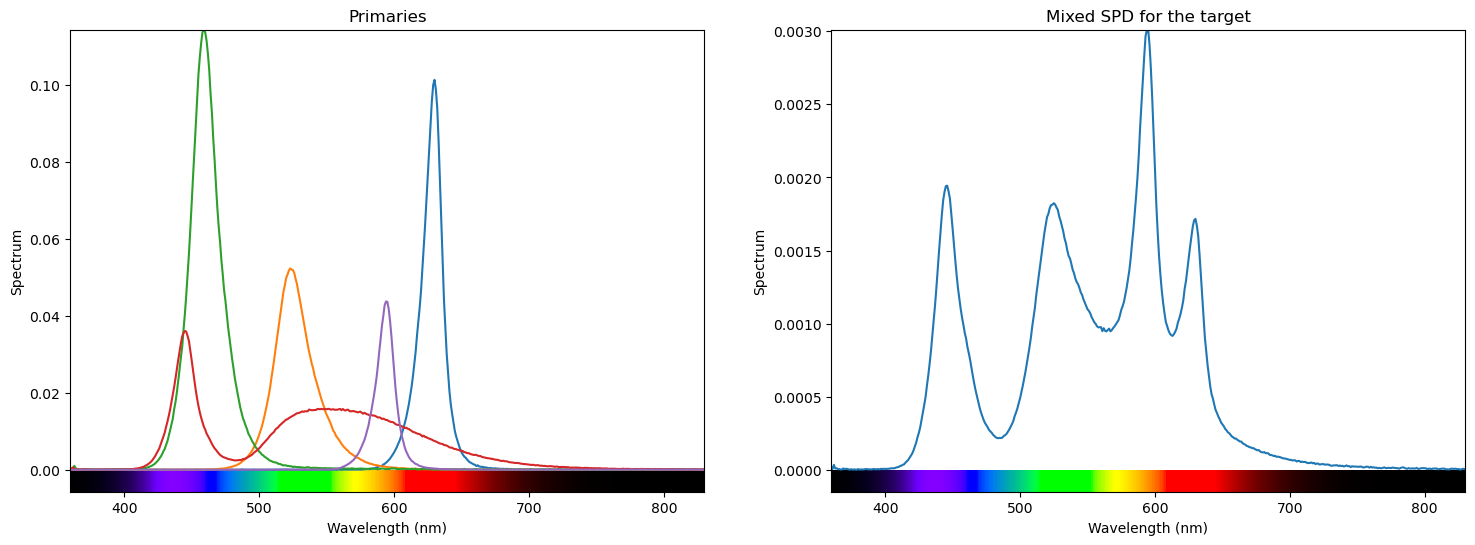

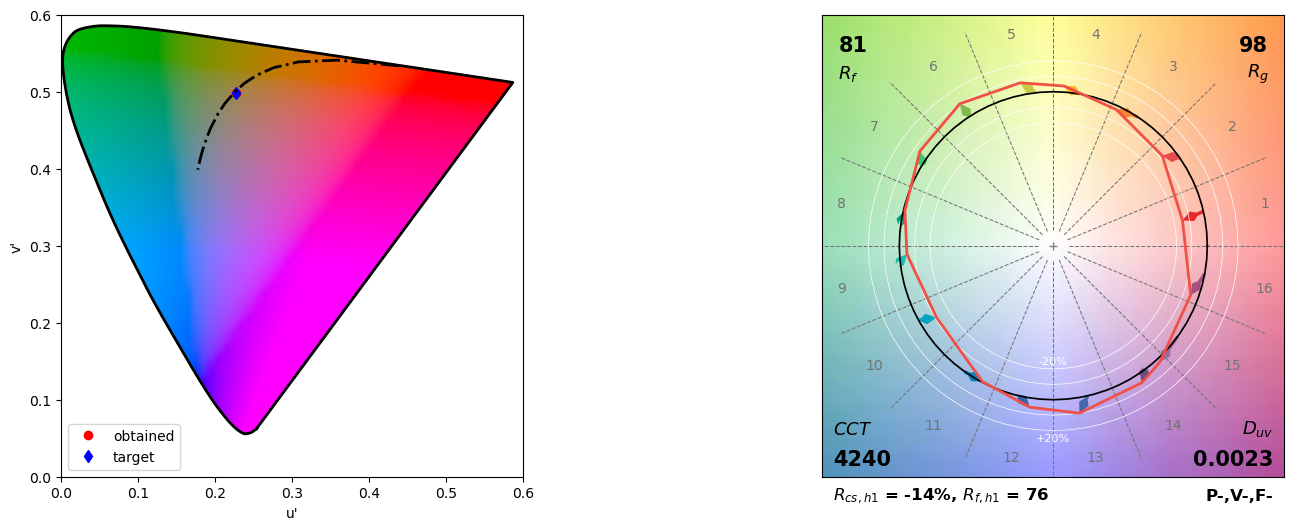


------Measured Result-------
Results (optim,target):
Rf: (78.54, 80.00)
Rg: (95.27, 95.00)
CCT [K]: (4127.4, 4000.0)
Duv: (0.0110, -0.0030)
LER [lm/W]: (404.4, 350.0)
Luminance [cd/m2] : 108.9
xyz : [ 104.4, 108.9, 57.8 ]
Target xyz : [ 102.5, 100.0, 68.4 ]
CCT: 4127.4
Duv: 0.01095
Rf: 78.5
Rg: 95.3
LER: 384.7
Obtained Lu*v*: 103.3418, 27.6533, 59.7469
Target Lu*v*: 100.0000, 37.6646, 38.4010
Obtained u': 0.2184
Target u': 0.2268
Obtained v': 0.5128
Target v': 0.4979
color difference in LUV space: 23.813
JNDs in u'v' chromaticity: 3


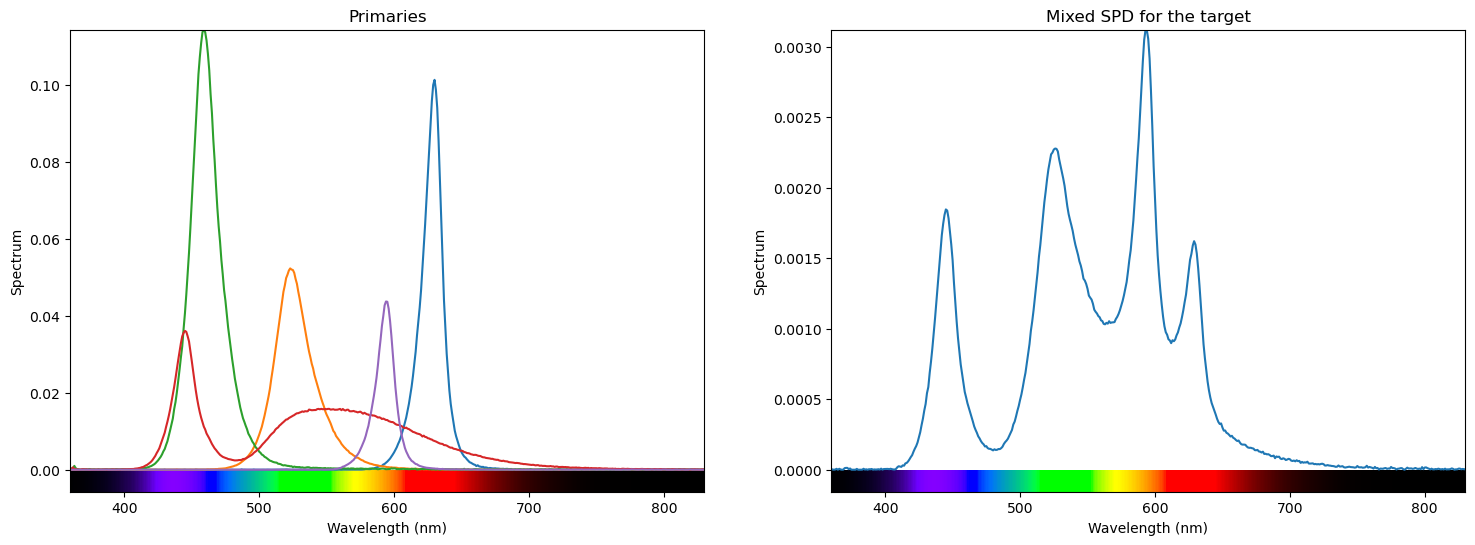

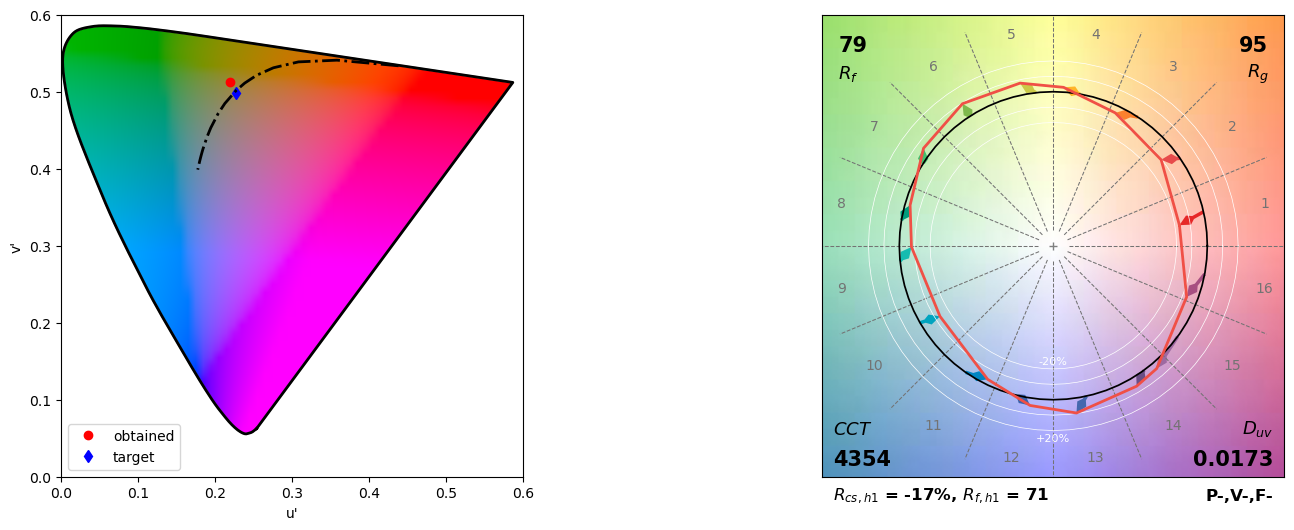

In [116]:
# %pip show luxpy
xyz_t = np.array([[100, 100, 200]])
Yxy_t = np.array([[100,1/3,1/3]])
cct_t = np.array([[4000, -0.003]])
channels_idx = [0, 1, 2, 3, 4]

spectralOptimization(channels_idx, target=xyz_t, tar_type='xyz',Rf_Rg=(80, 95), LER=350, method='particleswarm')
spectralOptimization(channels_idx, target=cct_t, tar_type='cct',Rf_Rg=(80, 95), LER=350, method='particleswarm')


In [12]:
dmx.close()